In [17]:
from google.colab import files
files.upload()  # Upload the kaggle.json you downloaded


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rupakakadia","key":"888675b3bf60ac12f3deafd6c6b9ddd2"}'}

In [18]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [19]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.68G/2.70G [00:23<00:00, 216MB/s]
100% 2.70G/2.70G [00:23<00:00, 124MB/s]


In [20]:
!unzip -q new-plant-diseases-dataset.zip


In [21]:
train_dir = '/content/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/content/New Plant Diseases Dataset(Augmented)/valid'


In [22]:
import os

# List what is there in /content
os.listdir('/content')


['.config',
 'new plant diseases dataset(augmented)',
 'kaggle.json',
 'test',
 'New Plant Diseases Dataset(Augmented)',
 'new-plant-diseases-dataset.zip',
 'sample_data']

In [23]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [24]:
import os

# List what is there in /content
os.listdir('/content')


['.config',
 'new plant diseases dataset(augmented)',
 'kaggle.json',
 'test',
 'New Plant Diseases Dataset(Augmented)',
 'new-plant-diseases-dataset.zip',
 'sample_data']

In [25]:
# Rename the correct folder to a simple name
!mv "New Plant Diseases Dataset(Augmented)" PlantVillage


In [26]:
train_dir = '/content/PlantVillage/train'
valid_dir = '/content/PlantVillage/valid'


In [27]:
os.listdir('/content/PlantVillage/New Plant Diseases Dataset(Augmented)')


['valid', 'train']

In [28]:
train_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/valid'


Total number of train classes: 38
Total number of valid classes: 38


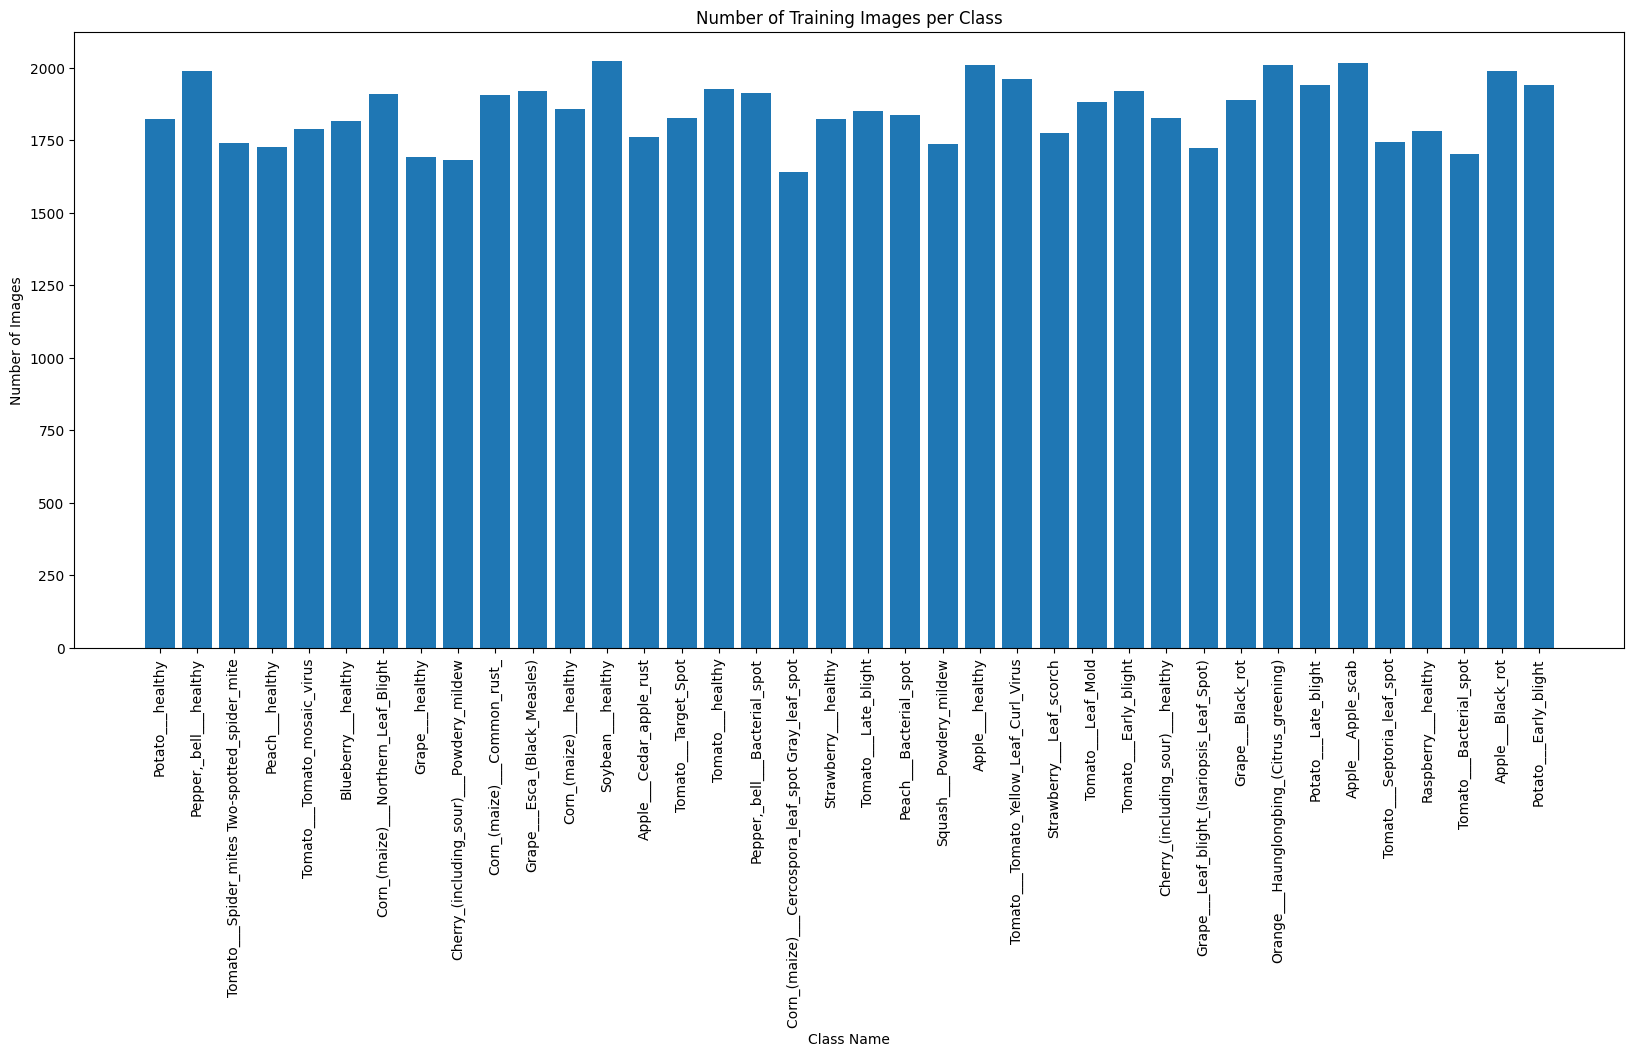

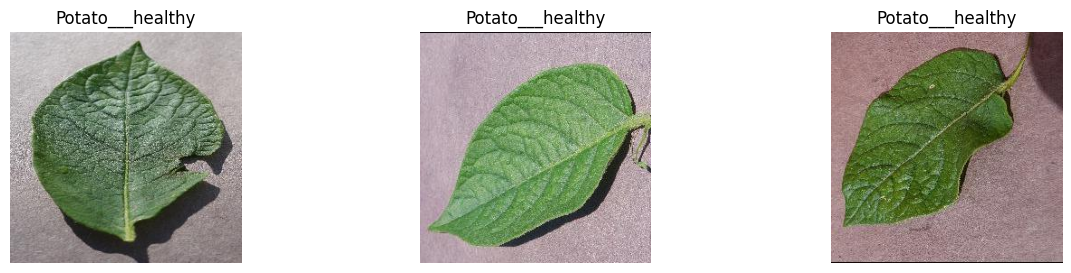

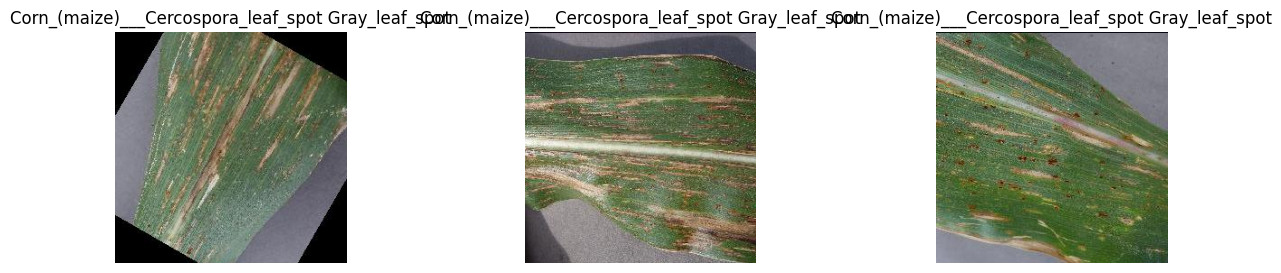

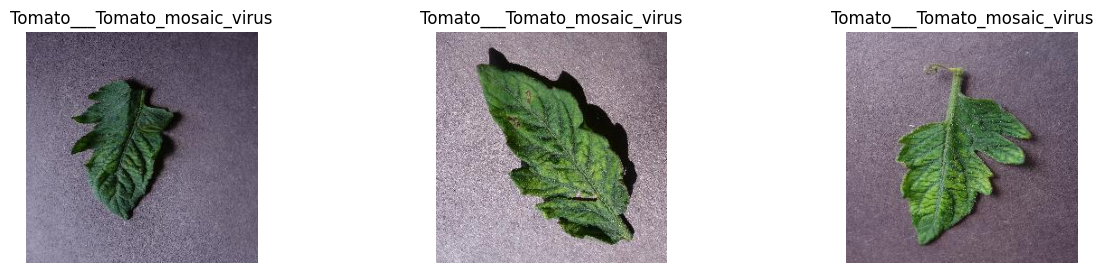

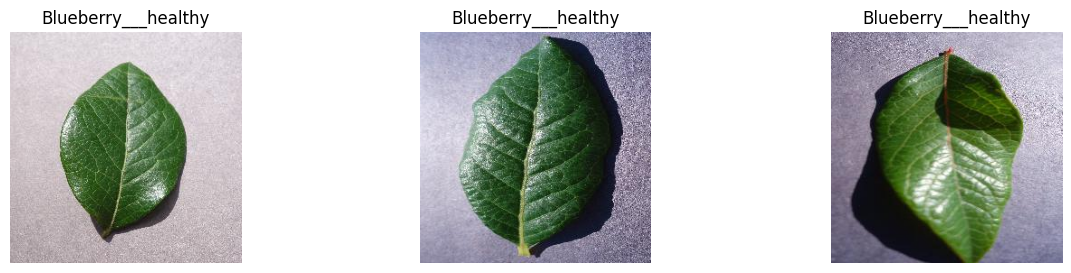

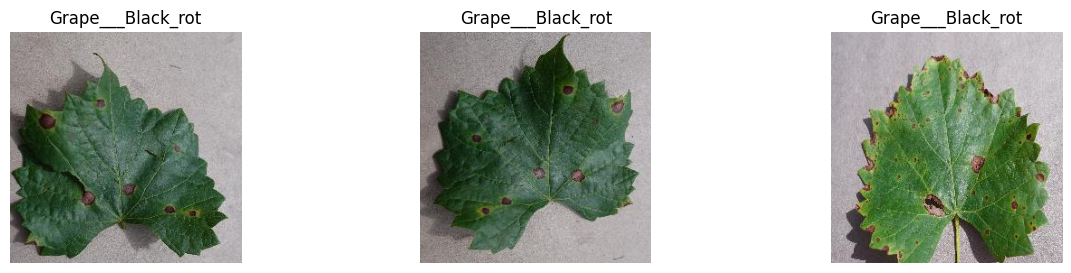

Sample Image Size (Width x Height): (256, 256)
Image Mode (RGB/Grayscale): RGB
Total corrupt images: 0 / 70295


In [29]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Set train and valid directories
train_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/valid'

# 1. List Classes
train_classes = os.listdir(train_dir)
valid_classes = os.listdir(valid_dir)
print(f"Total number of train classes: {len(train_classes)}")
print(f"Total number of valid classes: {len(valid_classes)}")

# 2. Number of Images in Each Class
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in train_classes}
valid_counts = {cls: len(os.listdir(os.path.join(valid_dir, cls))) for cls in valid_classes}

# 3. Plot Class Distribution (Training Data)
plt.figure(figsize=(20,8))
plt.bar(train_counts.keys(), train_counts.values())
plt.xticks(rotation=90)
plt.title("Number of Training Images per Class")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.show()

# 4. Show Sample Images from Random Train Classes
def show_sample_images(base_dir, num_classes=5, num_images_per_class=3):
    classes = os.listdir(base_dir)
    selected_classes = random.sample(classes, min(num_classes, len(classes)))
    for cls in selected_classes:
        folder = os.path.join(base_dir, cls)
        images = os.listdir(folder)
        images_to_show = random.sample(images, min(num_images_per_class, len(images)))
        plt.figure(figsize=(15, 3))
        for i, img_name in enumerate(images_to_show):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path)
            plt.subplot(1, len(images_to_show), i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
        plt.show()

show_sample_images(train_dir)

# 5. Check Image Sizes and Modes
sample_cls = random.choice(train_classes)
sample_img = random.choice(os.listdir(os.path.join(train_dir, sample_cls)))
sample_img_path = os.path.join(train_dir, sample_cls, sample_img)

img = Image.open(sample_img_path)
print(f"Sample Image Size (Width x Height): {img.size}")
print(f"Image Mode (RGB/Grayscale): {img.mode}")

# 6. Check for Corrupt Images
def check_corrupt_images(base_dir):
    error_count = 0
    total_images = 0
    for cls in os.listdir(base_dir):
        cls_folder = os.path.join(base_dir, cls)
        for img_name in os.listdir(cls_folder):
            try:
                img_path = os.path.join(cls_folder, img_name)
                img = Image.open(img_path)
                img.verify()
                total_images += 1
            except (IOError, SyntaxError) as e:
                error_count += 1
                print(f"Corrupt image: {img_path}")
    print(f"Total corrupt images: {error_count} / {total_images}")

check_corrupt_images(train_dir)


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report


In [31]:
train_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/test'  # (if you have test folder!)


In [32]:
# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data Loaders
batch_size = 32
img_height = 256
img_width = 256

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# If you have test set
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [33]:
num_classes = len(train_generator.class_indices)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Multi-class classification
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,095,654 (225.43 MB)

 Trainable params: 59,095,654 (225.43 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
img_height = 256
img_width = 256
batch_size = 32

train_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/valid'

# Create Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# ✅ Now train_generator is defined!


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [36]:
# Define number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")


Number of classes: 38


In [37]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load Pretrained ResNet50 without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final Model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,656,294 (94.06 MB)

 Trainable params: 1,068,582 (4.08 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters (Smaller size = faster training)
img_height = 224
img_width = 224
batch_size = 32

train_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/content/PlantVillage/New Plant Diseases Dataset(Augmented)/valid'

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of Classes: {num_classes}")


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Number of Classes: 38


In [39]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load Pretrained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,933,350 (11.19 MB)

 Trainable params: 675,366 (2.58 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [checkpoint, early_stop]


In [41]:
epochs = 10  # You can increase if you want, depending on time

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=callbacks
)


Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5847 - loss: 1.5671

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 223s 96ms/step - accuracy: 0.5847 - loss: 1.5668 - val_accuracy: 0.9161 - val_loss: 0.2931
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8889 - loss: 0.3649

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 163s 74ms/step - accuracy: 0.8889 - loss: 0.3649 - val_accuracy: 0.9383 - val_loss: 0.2019
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9219 - loss: 0.2500

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 163s 74ms/step - accuracy: 0.9219 - loss: 0.2500 - val_accuracy: 0.9486 - val_loss: 0.1671
Epoch 4/10
2196/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9363 - loss: 0.1992

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 165s 75ms/step - accuracy: 0.9364 - loss: 0.1992 - val_accuracy: 0.9546 - val_loss: 0.1473
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9462 - loss: 0.1691

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 176s 80ms/step - accuracy: 0.9462 - loss: 0.1691 - val_accuracy: 0.9591 - val_loss: 0.1283
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 165s 75ms/step - accuracy: 0.9544 - loss: 0.1427 - val_accuracy: 0.9590 - val_loss: 0.1236
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9600 - loss: 0.1235

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 163s 74ms/step - accuracy: 0.9600 - loss: 0.1235 - val_accuracy: 0.9630 - val_loss: 0.1129
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9639 - loss: 0.1115

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 162s 74ms/step - accuracy: 0.9639 - loss: 0.1115 - val_accuracy: 0.9651 - val_loss: 0.1063
Epoch 9/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9675 - loss: 0.1019

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 162s 74ms/step - accuracy: 0.9675 - loss: 0.1019 - val_accuracy: 0.9655 - val_loss: 0.1036
Epoch 10/10
2196/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9711 - loss: 0.0917

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 163s 74ms/step - accuracy: 0.9711 - loss: 0.0917 - val_accuracy: 0.9673 - val_loss: 0.0966


In [42]:
model.save("model.h5")
print("✅ Model saved to model.h5")


✅ Model saved to model.h5


In [51]:
from google.colab import files
files.download("model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

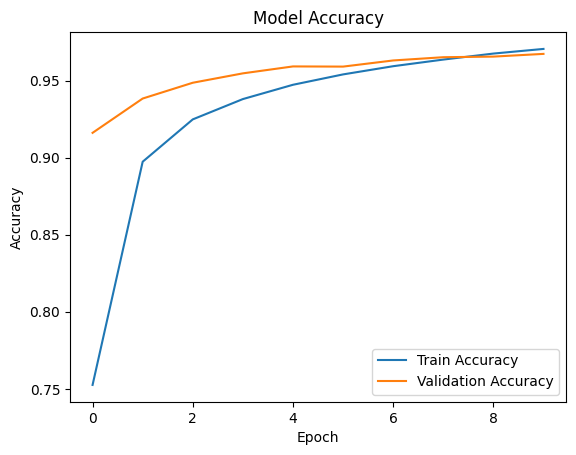

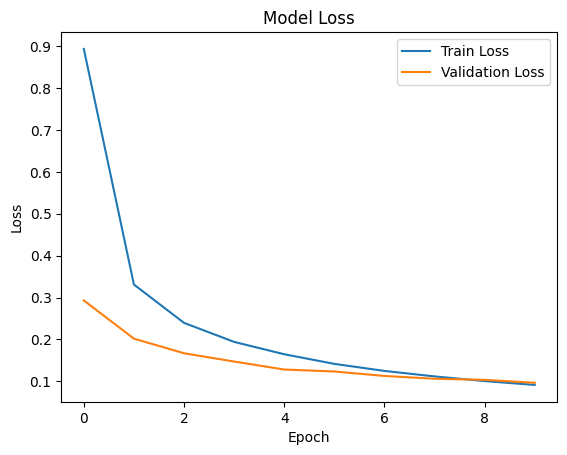

In [43]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [44]:
from tensorflow.keras.models import load_model

# Load the saved best model
best_model = load_model('best_model.h5')


In [45]:
import os

# List all folders in /content
os.listdir('/content')


['.config',
 'model.h5',
 'new plant diseases dataset(augmented)',
 'PlantVillage',
 'kaggle.json',
 'best_model.h5',
 'test',
 'new-plant-diseases-dataset.zip',
 'sample_data']

In [46]:
test_dir = '/content/test'


In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for keeping order
)


Found 33 images belonging to 1 classes.


In [48]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')


In [49]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)


Found 33 images belonging to 1 classes.


In [50]:
# Predict
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# No y_true here because test data has no labels!

# Just predict and maybe save the predictions:
import pandas as pd

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames, "PredictedClass": y_pred})

# Save to CSV
results.to_csv("test_predictions.csv", index=False)

print(results.head())


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
                   Filename  PredictedClass
0  test/AppleCedarRust1.JPG               2
1  test/AppleCedarRust2.JPG               2
2  test/AppleCedarRust3.JPG               2
3  test/AppleCedarRust4.JPG               2
4       test/AppleScab1.JPG               0
